# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


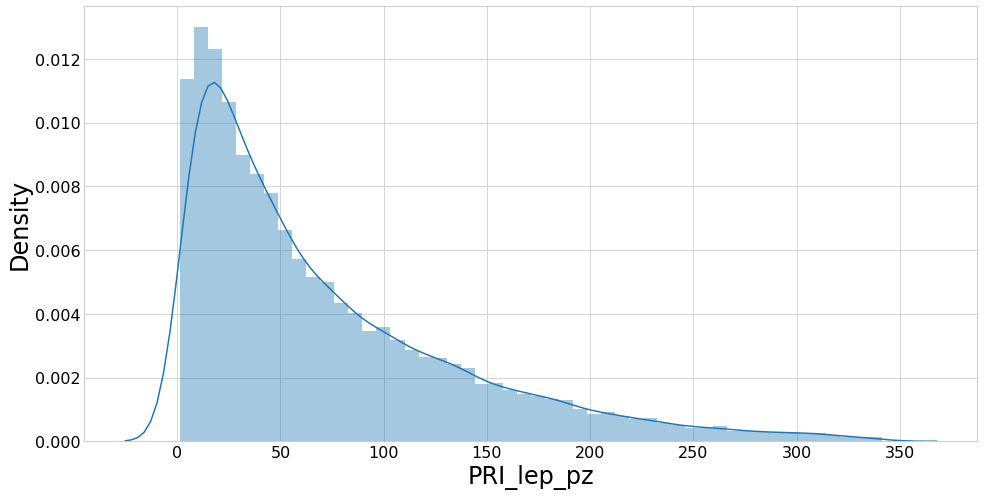

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


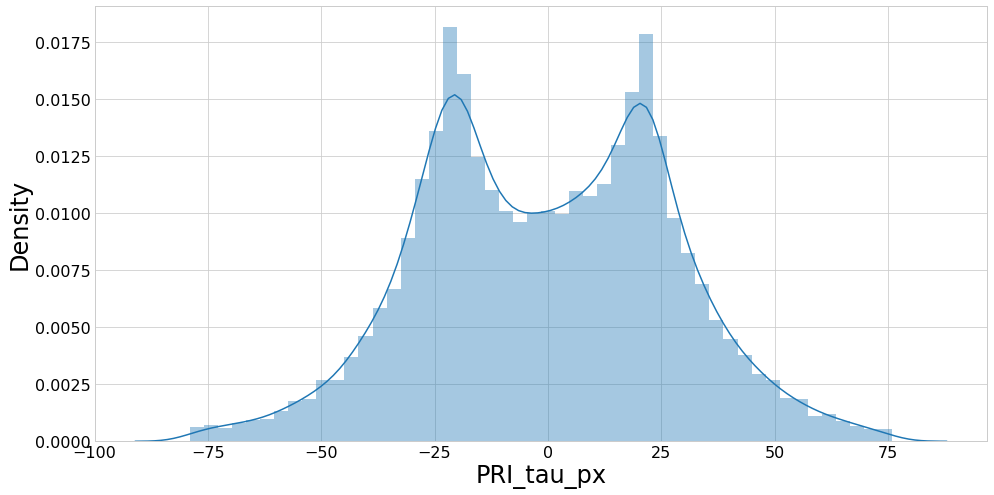

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


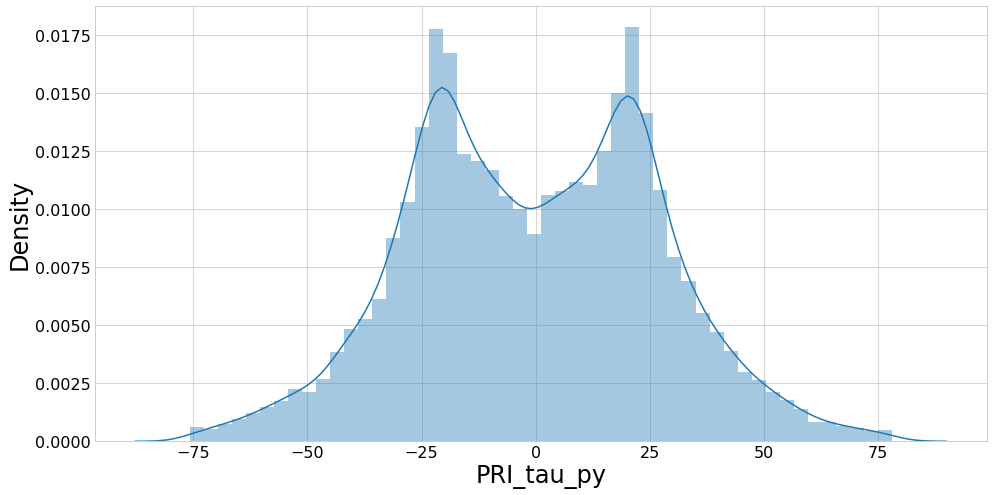

In [6]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')
plot_feat(data, 'PRI_tau_px')
plot_feat(data, 'PRI_tau_py')

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 18.362s 


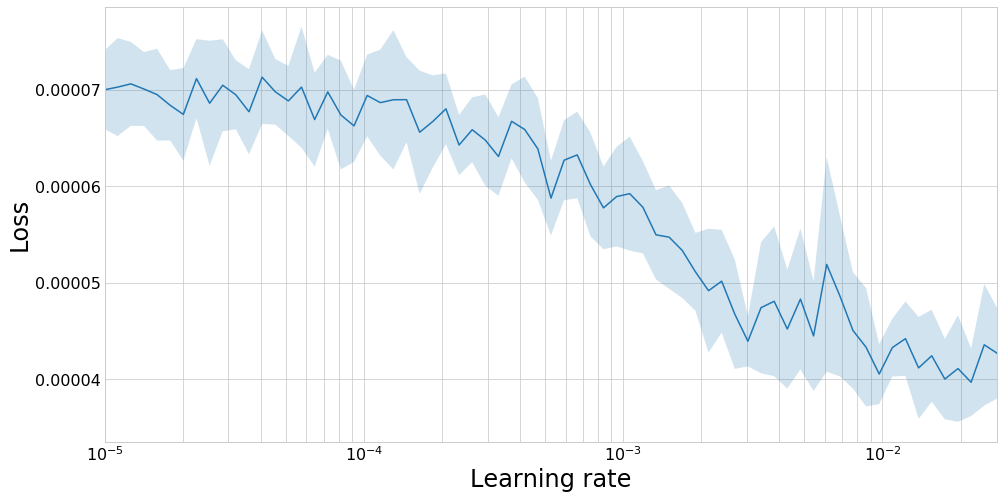

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106043). Check your callbacks.
  % delta_t_median)


1 New best found: 3.942298282403338e-05
2 New best found: 3.6797582642115646e-05
3 New best found: 3.606881402689016e-05
5 New best found: 3.497311551014986e-05
6 New best found: 3.452706506673068e-05
7 New best found: 3.435112230343756e-05
10 New best found: 3.415775754358438e-05
11 New best found: 3.393315197755651e-05
12 New best found: 3.387970282575668e-05
13 New best found: 3.341418986363577e-05
14 New best found: 3.33395368151648e-05
15 New best found: 3.333545208524325e-05
20 New best found: 3.32324558595525e-05
23 New best found: 3.3080064636971104e-05
24 New best found: 3.29648762320535e-05
25 New best found: 3.281372371897654e-05
26 New best found: 3.279988482813072e-05
27 New best found: 3.273274241725915e-05
28 New best found: 3.2628866990712824e-05
30 New best found: 3.262884683268042e-05
31 New best found: 3.2628581741323306e-05
46 New best found: 3.257980556294483e-05
53 New best found: 3.243074701295484e-05
55 New best found: 3.235047713913642e-05
93 New best found: 3.

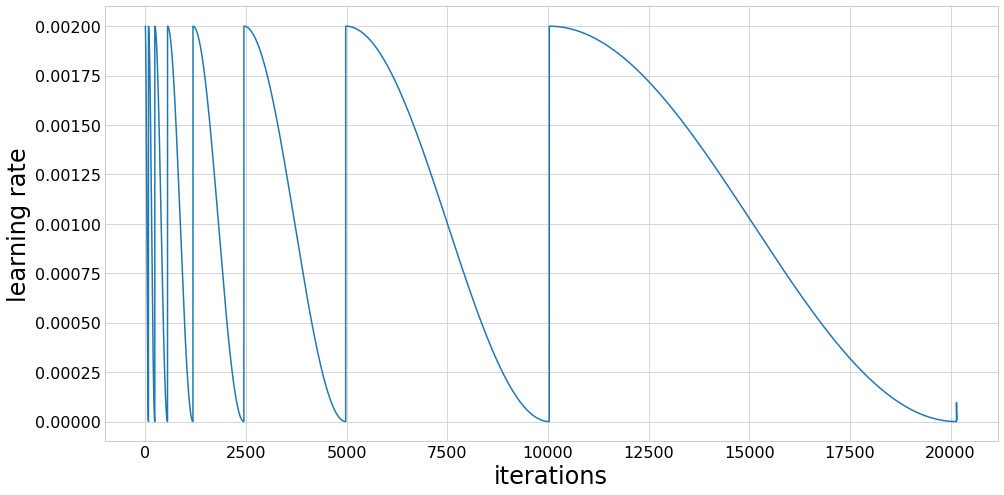

Fold took 289.783s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120044). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9953239371243396e-05
2 New best found: 3.620854913606308e-05
3 New best found: 3.555038905906258e-05
4 New best found: 3.5075108840828764e-05
5 New best found: 3.461756317556137e-05
6 New best found: 3.408905025571585e-05
7 New best found: 3.391918077832088e-05
10 New best found: 3.3791037590708584e-05
11 New best found: 3.3453847549390045e-05
12 New best found: 3.344448240677593e-05
13 New best found: 3.302909831108991e-05
14 New best found: 3.300285486620851e-05
19 New best found: 3.280352338188095e-05
24 New best found: 3.260325681476388e-05
25 New best found: 3.236215355573222e-05
26 New best found: 3.233755878609372e-05
27 New best found: 3.226833329536021e-05
28 New best found: 3.220324610592797e-05
29 New best found: 3.214984983060276e-05
30 New best found: 3.2134723689523524e-05
31 New best found: 3.2132419347180986e-05
47 New best found: 3.2068168884143234e-05
49 New best found: 3.1997225320083086e-05
53 New best found: 3.19241810895619e-05
56 New best foun

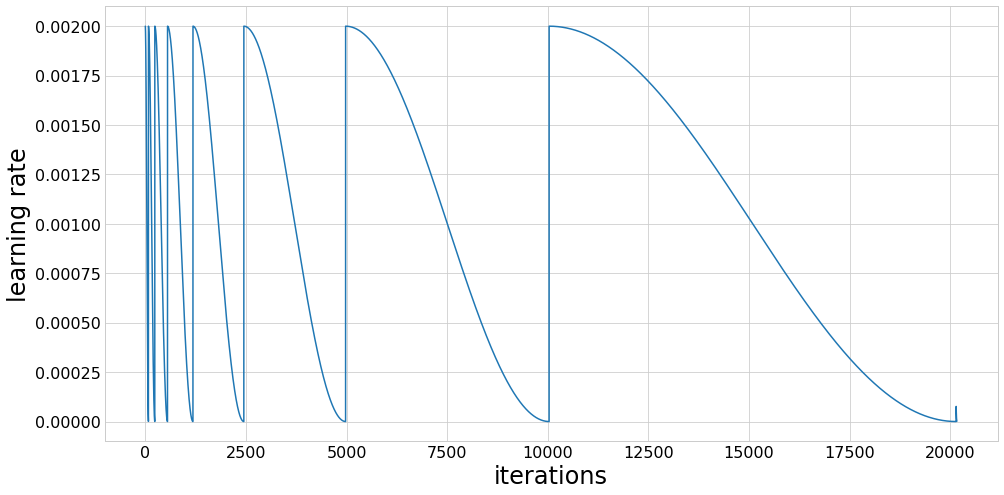

Fold took 303.097s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.279218). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140039). Check your callbacks.
  % delta_t_median)


1 New best found: 4.091399100307869e-05
2 New best found: 3.658389748694952e-05
3 New best found: 3.601817011622852e-05
4 New best found: 3.5532720098948845e-05
5 New best found: 3.477101201910843e-05
6 New best found: 3.435505292326698e-05
7 New best found: 3.4151152497166884e-05
10 New best found: 3.400787536145818e-05
11 New best found: 3.374137602544228e-05
12 New best found: 3.3444523203063584e-05
14 New best found: 3.330029496794279e-05
15 New best found: 3.326888181580218e-05
24 New best found: 3.299484400704876e-05
25 New best found: 3.27754493185634e-05
27 New best found: 3.265929950684664e-05
28 New best found: 3.262113035920533e-05
29 New best found: 3.2574575712043715e-05
30 New best found: 3.254943811995461e-05
31 New best found: 3.2546941199243654e-05
49 New best found: 3.253196506637483e-05
50 New best found: 3.2506545607003604e-05
52 New best found: 3.2443162924999895e-05
54 New best found: 3.2420010863249134e-05
55 New best found: 3.2348579041113326e-05
57 New best fou

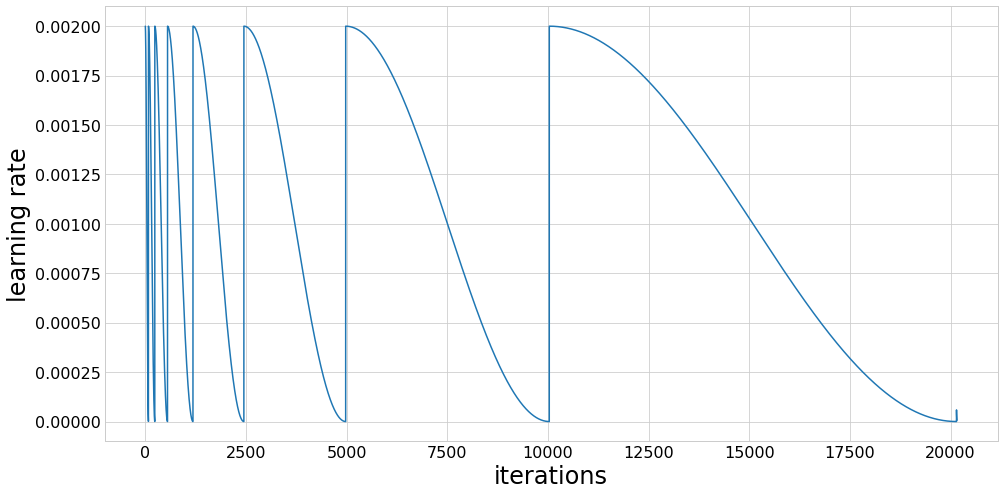

Fold took 299.463s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300063). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150445). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0532774290324515e-05
2 New best found: 3.688213098529902e-05
3 New best found: 3.644268752289821e-05
4 New best found: 3.5841753230690166e-05
5 New best found: 3.52012395216737e-05
6 New best found: 3.473515983724309e-05
7 New best found: 3.466466942814392e-05
9 New best found: 3.458597359286265e-05
11 New best found: 3.441685568709633e-05
12 New best found: 3.400629561180916e-05
13 New best found: 3.3846897058669135e-05
14 New best found: 3.368483956786734e-05
15 New best found: 3.365580001315978e-05
24 New best found: 3.345696757282333e-05
26 New best found: 3.319895884830129e-05
27 New best found: 3.319096248411317e-05
28 New best found: 3.3060959049676086e-05
50 New best found: 3.3004805955803064e-05
51 New best found: 3.293001860103481e-05
53 New best found: 3.276646074139472e-05
59 New best found: 3.276148359492053e-05
60 New best found: 3.2740331837410504e-05
96 New best found: 3.271545595363155e-05
98 New best found: 3.259772885075611e-05
99 New best found: 

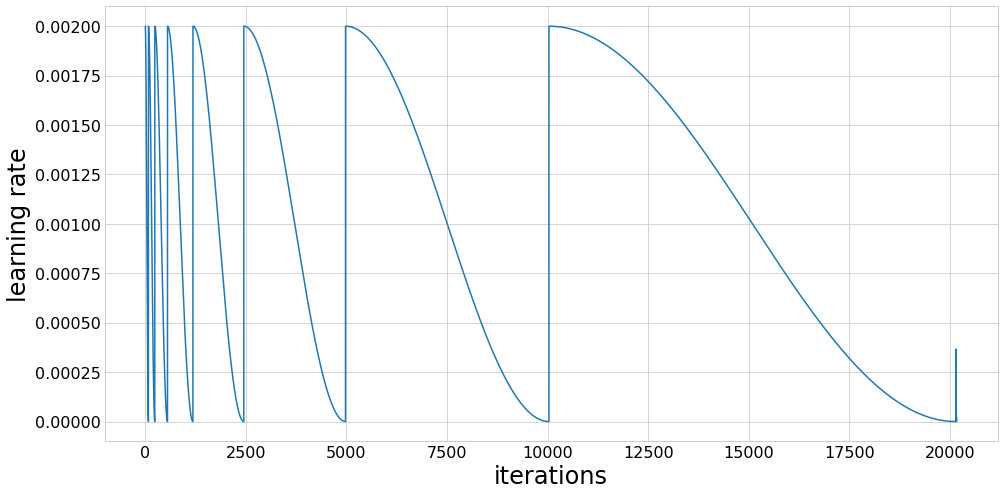

Fold took 317.980s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.306253). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153502). Check your callbacks.
  % delta_t_median)


1 New best found: 4.027348789785561e-05
2 New best found: 3.5968703279309394e-05
3 New best found: 3.553672113020658e-05
4 New best found: 3.521526977098854e-05
5 New best found: 3.503122816752214e-05
6 New best found: 3.418149386411831e-05
7 New best found: 3.402356066321465e-05
10 New best found: 3.3953471938311874e-05
11 New best found: 3.363332948834553e-05
12 New best found: 3.341410590191022e-05
13 New best found: 3.3388811892158944e-05
14 New best found: 3.3216330622531064e-05
15 New best found: 3.319136679369961e-05
22 New best found: 3.304205649298776e-05
24 New best found: 3.287509389509742e-05
25 New best found: 3.287445805202037e-05
26 New best found: 3.2794750384215266e-05
27 New best found: 3.272489567787872e-05
28 New best found: 3.260970145835555e-05
30 New best found: 3.25753792310141e-05
31 New best found: 3.256822127990548e-05
47 New best found: 3.238549525377253e-05
51 New best found: 3.2364734386861155e-05
55 New best found: 3.222604182276649e-05
57 New best found:

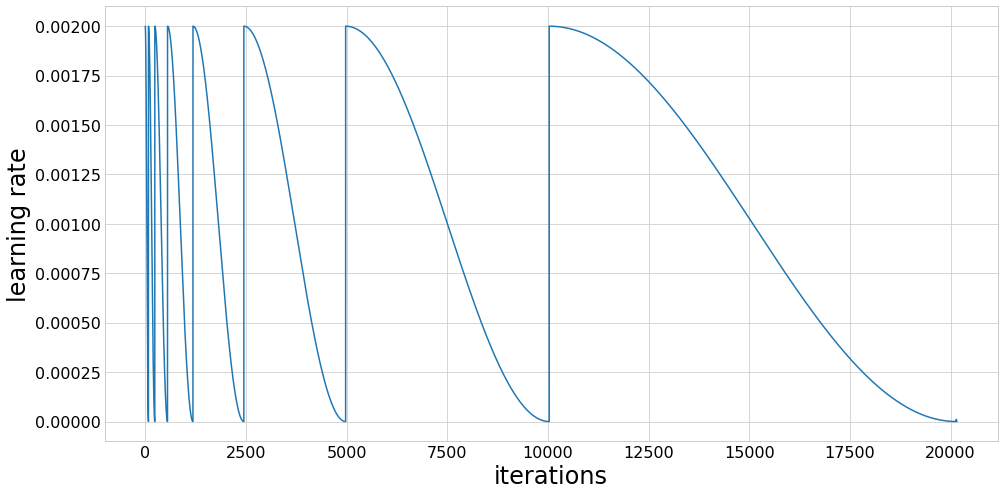

Fold took 309.334s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.387875). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194360). Check your callbacks.
  % delta_t_median)


1 New best found: 3.92612175346585e-05
2 New best found: 3.660492692433763e-05
3 New best found: 3.6186718041426504e-05
5 New best found: 3.5285605693934487e-05
6 New best found: 3.4400446276413274e-05
7 New best found: 3.4313410858158024e-05
10 New best found: 3.426590623566881e-05
11 New best found: 3.385594370192848e-05
12 New best found: 3.376446873444365e-05
13 New best found: 3.330313595797634e-05
14 New best found: 3.319944180839229e-05
15 New best found: 3.3165985750383696e-05
23 New best found: 3.2946386840194466e-05
24 New best found: 3.2882201617758257e-05
25 New best found: 3.28685470711207e-05
26 New best found: 3.2667369297996626e-05
27 New best found: 3.251341891591437e-05
29 New best found: 3.2478514245303814e-05
30 New best found: 3.2454973252606576e-05
49 New best found: 3.236772848758847e-05
50 New best found: 3.2344823282619474e-05
51 New best found: 3.2229166183242344e-05
52 New best found: 3.218255799802137e-05
54 New best found: 3.2069584884447976e-05
55 New best

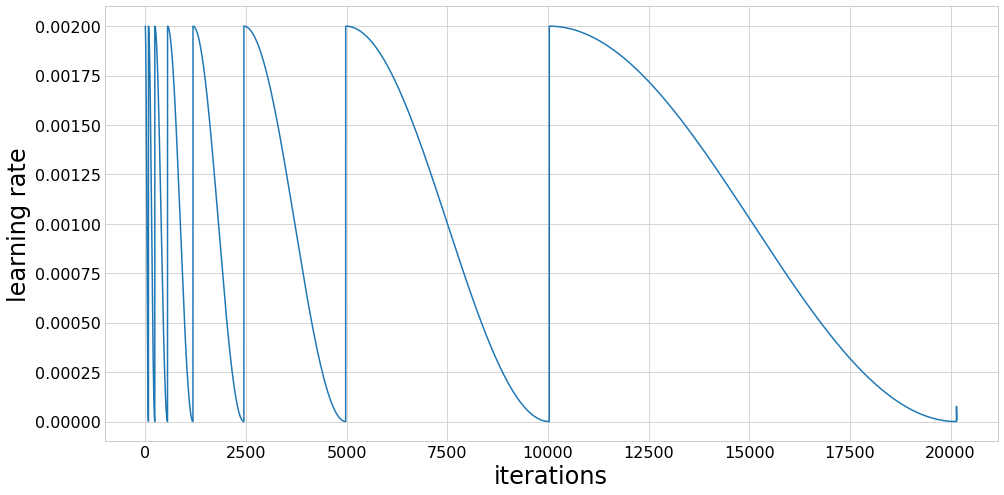

Fold took 308.837s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.407743). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204344). Check your callbacks.
  % delta_t_median)


1 New best found: 4.064868426798996e-05
2 New best found: 3.6508699234187726e-05
3 New best found: 3.608093719822093e-05
5 New best found: 3.51312339784389e-05
6 New best found: 3.462601876354957e-05
7 New best found: 3.446221584977346e-05
10 New best found: 3.424986002134315e-05
11 New best found: 3.378414049163007e-05
12 New best found: 3.355874690116395e-05
13 New best found: 3.341373531814087e-05
14 New best found: 3.3300766424140295e-05
15 New best found: 3.3270183796864465e-05
22 New best found: 3.32496483091261e-05
24 New best found: 3.30535916180599e-05
25 New best found: 3.287798891611197e-05
26 New best found: 3.284676437376055e-05
27 New best found: 3.280363049057804e-05
29 New best found: 3.2742205094437865e-05
30 New best found: 3.270432804660985e-05
31 New best found: 3.269847679964422e-05
44 New best found: 3.257019799072667e-05
49 New best found: 3.256388550538571e-05
52 New best found: 3.237294970688836e-05
53 New best found: 3.234169798238298e-05
56 New best found: 3.

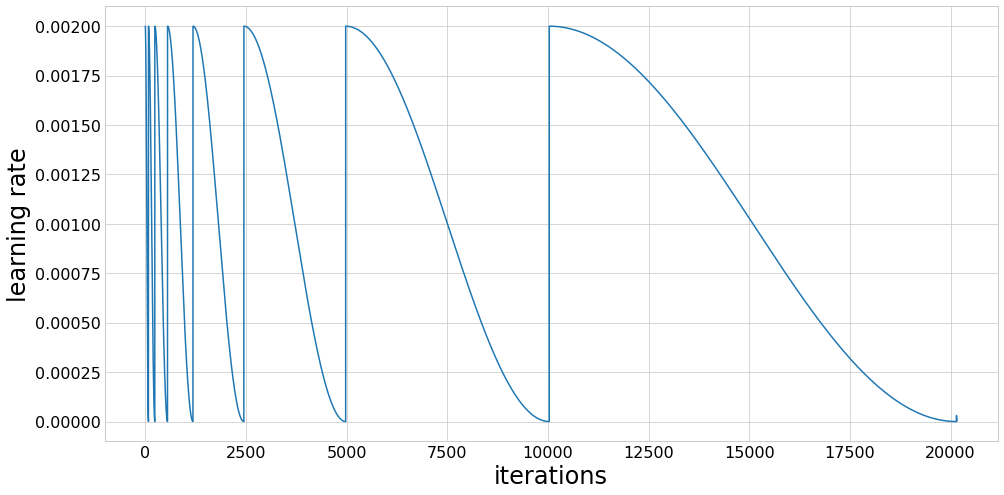

Fold took 312.368s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408331). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204615). Check your callbacks.
  % delta_t_median)


1 New best found: 4.049315331326003e-05
2 New best found: 3.69764325268769e-05
3 New best found: 3.645998173714672e-05
4 New best found: 3.6007615061746444e-05
5 New best found: 3.522899847628012e-05
6 New best found: 3.4719028586079525e-05
7 New best found: 3.4651245635336314e-05
9 New best found: 3.460473270251816e-05
10 New best found: 3.452053387047216e-05
11 New best found: 3.409740313933201e-05
12 New best found: 3.373421164060131e-05
13 New best found: 3.364430168580438e-05
14 New best found: 3.3531961734471644e-05
15 New best found: 3.3515711312534285e-05
21 New best found: 3.342169394195977e-05
24 New best found: 3.3297617685631054e-05
25 New best found: 3.3199143662045054e-05
26 New best found: 3.301575166259922e-05
27 New best found: 3.299246289796362e-05
28 New best found: 3.294222470208773e-05
29 New best found: 3.28702356236261e-05
30 New best found: 3.284046457295788e-05
31 New best found: 3.283773422647809e-05
44 New best found: 3.273437087606936e-05
48 New best found: 

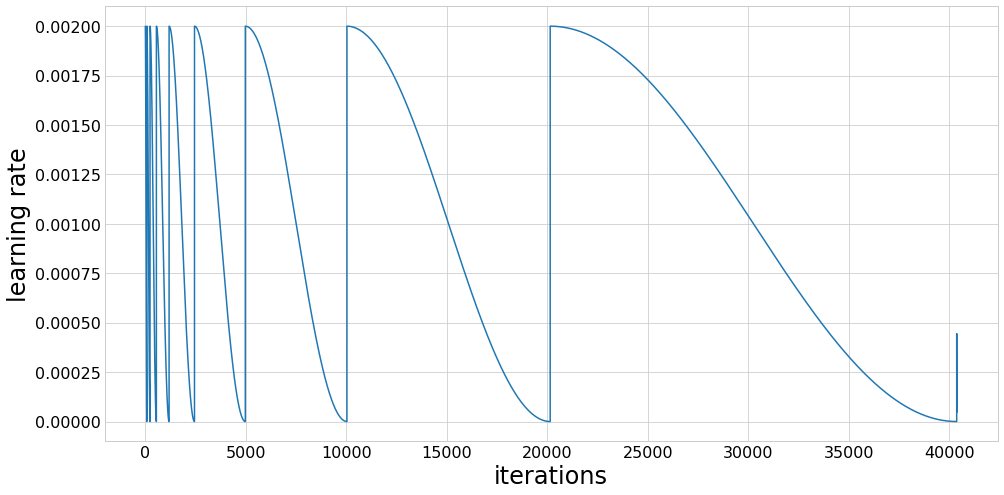

Fold took 609.973s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.477077). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239020). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9486126373230946e-05
2 New best found: 3.5541187493072355e-05
3 New best found: 3.501280120253796e-05
4 New best found: 3.426906641252572e-05
5 New best found: 3.3774446598545186e-05
6 New best found: 3.331790277152322e-05
7 New best found: 3.3176429483864924e-05
10 New best found: 3.272259392906563e-05
12 New best found: 3.231177035340807e-05
13 New best found: 3.21142196728033e-05
14 New best found: 3.209452601877274e-05
15 New best found: 3.2054010787396694e-05
20 New best found: 3.201042642322136e-05
21 New best found: 3.181089982099365e-05
23 New best found: 3.175491458241595e-05
24 New best found: 3.1692317614215426e-05
26 New best found: 3.149576513606007e-05
27 New best found: 3.1465990456490544e-05
28 New best found: 3.139287009325926e-05
29 New best found: 3.136924955615541e-05
30 New best found: 3.1356519585096976e-05
31 New best found: 3.135167163200094e-05
45 New best found: 3.132962261661305e-05
46 New best found: 3.125212467857637e-05
49 New best foun

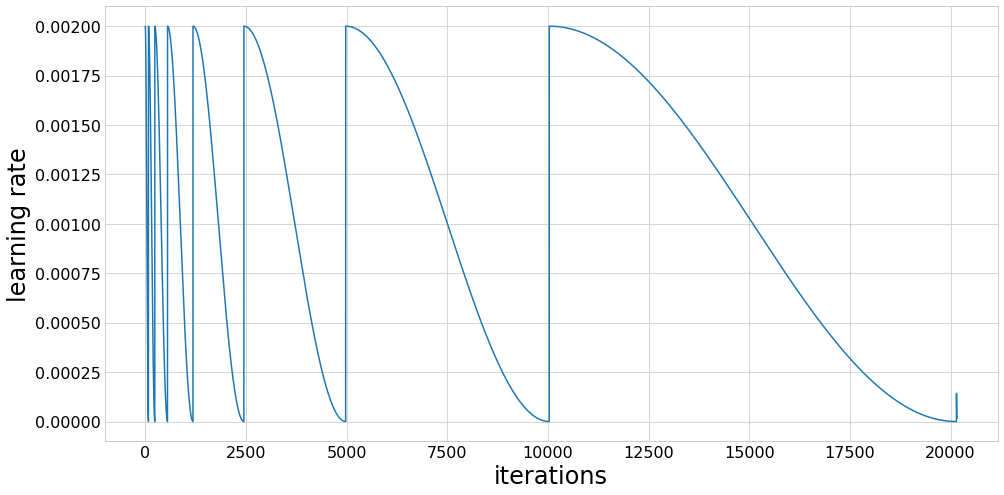

Fold took 317.667s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.486135). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.243484). Check your callbacks.
  % delta_t_median)


1 New best found: 4.001686090778094e-05
2 New best found: 3.6239587803720496e-05
3 New best found: 3.577805121021811e-05
4 New best found: 3.570656988740666e-05
5 New best found: 3.520696996274637e-05
6 New best found: 3.461545123718679e-05
7 New best found: 3.456445165356854e-05
9 New best found: 3.4464591734285934e-05
10 New best found: 3.416025087644812e-05
11 New best found: 3.384058590017958e-05
12 New best found: 3.3827782557636964e-05
13 New best found: 3.351112115487922e-05
14 New best found: 3.342326311249053e-05
15 New best found: 3.3389688456372824e-05
20 New best found: 3.332211440865649e-05
22 New best found: 3.315704800916137e-05
23 New best found: 3.313929802970961e-05
26 New best found: 3.2889096123108174e-05
27 New best found: 3.2839808956487106e-05
28 New best found: 3.274337916664081e-05
29 New best found: 3.2707578470581214e-05
42 New best found: 3.2704141800059003e-05
45 New best found: 3.2651034272566904e-05
46 New best found: 3.24993489724875e-05
51 New best foun

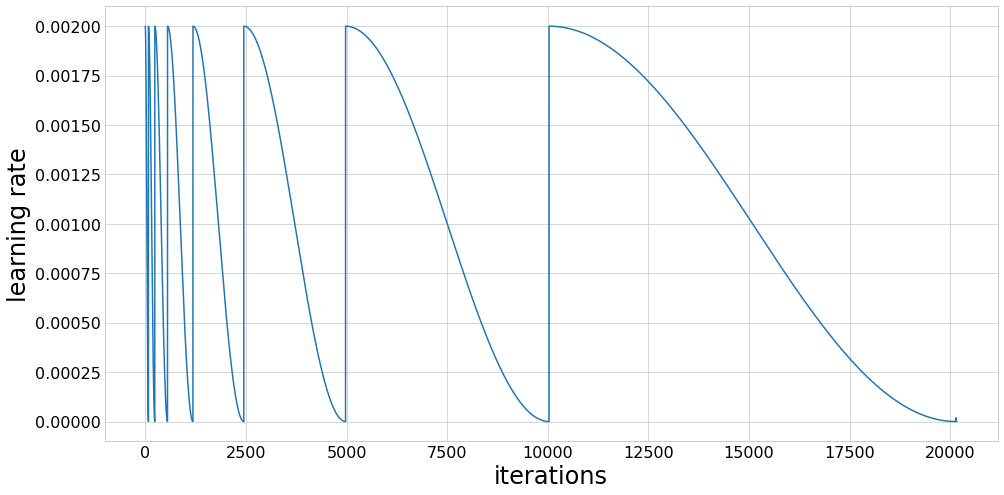

Fold took 336.940s


______________________________________
Training finished
Cross-validation took 3408.883s 


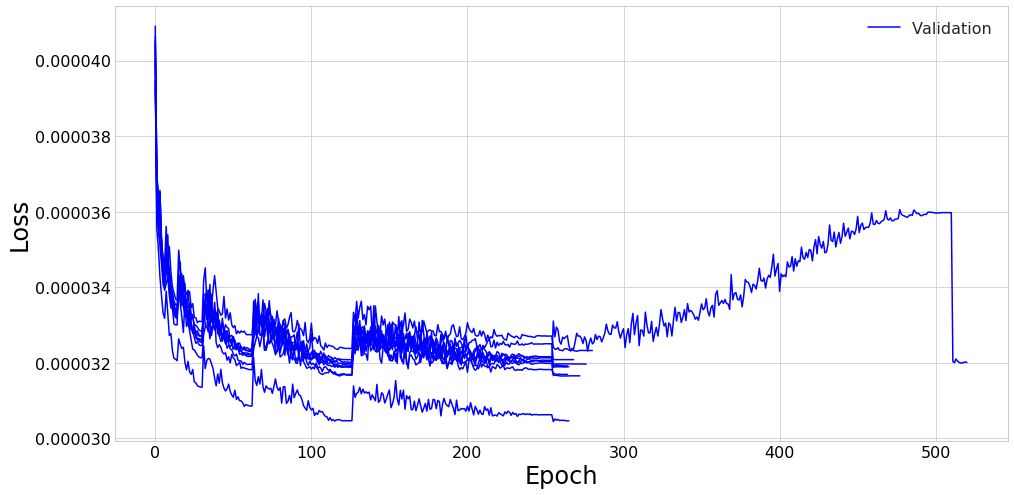

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0635 +- 0.0006
Mean AUC = 0.0987 +- 0.0008
Mean AMS = 4.0 +- 0.2
Mean cut = 0.955 +- 0.009
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 8 with loss = 3.0443305376684294e-05
Model 1 is 1 with loss = 3.164731475408189e-05
Model 2 is 5 with loss = 3.1683138520747886e-05
Model 3 is 0 with loss = 3.1878830267540946e-05
Model 4 is 6 with loss = 3.1883194130508726e-05
Model 5 is 2 with loss = 3.1909811977405556e-05
Model 6 is 7 with loss = 3.1947117355821625e-05
Model 7 is 9 with loss = 3.196609743972658e-05
Model 8 is 4 with loss = 3.208028240807016e-05
Model 9 is 3 with loss = 3.230273268974094e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001944294385612011s per sample

Predicting fold 2 out of 10
Prediction took 0.0003588532708585262s per sample

Predicting fold 3 out of 10
Prediction took 0.0003541582174599171s per sample

Predicting fold 4 out of 10
Prediction took 0.0003596360094845295s per sample

Predicting fold 5 out of 10
Prediction took 0.0003560003787279129s per sample

Predicting fold 6 out of 10
Prediction took 0.0003534973040223122s per sample

Predicting fold 7 out of 10
Prediction took 0.00035174458622932433s per sample

Predicting fold 8 out of 10
Prediction took 0.0003522119306027889s per sample

Predicting fold 9 out of 10
Prediction took 0.0003562521442770958s per sample

Predicting fold 10 out of 10
Prediction took 0.00036738588735461234s per sample



In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.90327469315589, weighted 0.9356785071203336


In [15]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.941318469407802, 0.9671857)

In [16]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9624976711347699, corresponds to calc_ams of 3.803059729572228
CPU times: user 2.16 s, sys: 14.3 s, total: 16.5 s
Wall time: 2min 26s


(4.0, 0.96)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [17]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005944426444917918s per sample

Predicting fold 2 out of 10
Prediction took 0.005995551608502864s per sample

Predicting fold 3 out of 10
Prediction took 0.005932122339308262s per sample

Predicting fold 4 out of 10
Prediction took 0.005995904759317636s per sample

Predicting fold 5 out of 10
Prediction took 0.005990978033840656s per sample

Predicting fold 6 out of 10
Prediction took 0.005955159736424685s per sample

Predicting fold 7 out of 10
Prediction took 0.006013925211876631s per sample

Predicting fold 8 out of 10
Prediction took 0.006020813605189323s per sample

Predicting fold 9 out of 10
Prediction took 0.005914000642299652s per sample

Predicting fold 10 out of 10
Prediction took 0.005932803840190172s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9033676403417406, weighted 0.9356975899478248


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.9463901961375343, 0.9602238)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.96+-0.01
Exact mean cut 0.9612920759245753, corresponds to calc_ams of 3.913074439416677
CPU times: user 2.2 s, sys: 14.6 s, total: 16.8 s
Wall time: 2min 26s


(4.0, 0.96)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00035462403615767305s per sample

Predicting fold 2 out of 10
Prediction took 0.0003529114851897413s per sample

Predicting fold 3 out of 10
Prediction took 0.00035787610587748617s per sample

Predicting fold 4 out of 10
Prediction took 0.000352650928565047s per sample

Predicting fold 5 out of 10
Prediction took 0.00034768371399153365s per sample

Predicting fold 6 out of 10
Prediction took 0.00035417531911622393s per sample

Predicting fold 7 out of 10
Prediction took 0.00035340434353459967s per sample

Predicting fold 8 out of 10
Prediction took 0.0003483333918858658s per sample

Predicting fold 9 out of 10
Prediction took 0.00034865833012895153s per sample

Predicting fold 10 out of 10
Prediction took 0.000348296389661052s per sample

CPU times: user 3min 28s, sys: 16.2 s, total: 3min 44s
Wall time: 3min 13s


In [24]:
score_test_data(test_fy.source, 0.9624976711347699)

Public:Private AMS: 3.573353116069004 : 3.7239037983271275


(3.573353116069004, 3.7239037983271275)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [25]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                             rotate=True, reflect_x=False, reflect_y=True, reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005744677494804968s per sample

Predicting fold 2 out of 10
Prediction took 0.005762621922858736s per sample

Predicting fold 3 out of 10
Prediction took 0.005727573858811097s per sample

Predicting fold 4 out of 10
Prediction took 0.005733118963783437s per sample

Predicting fold 5 out of 10
Prediction took 0.005748040554875677s per sample

Predicting fold 6 out of 10
Prediction took 0.005767637683789838s per sample

Predicting fold 7 out of 10
Prediction took 0.005720492124557495s per sample

Predicting fold 8 out of 10


In [28]:
score_test_data(test_fy.source, 0.9612920759245753)

Public:Private AMS: 3.625425644074069 : 3.744043058909289


(3.625425644074069, 3.744043058909289)

In [ ]:
score_test_data(test_fy.source, 0.9538)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)